In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [7]:
# Read CSV file
file_path = r"/workspaces/rumour-detection-pheme/Dataset creation/charliehebdo-all-rnr-threads.csv"
df = pd.read_csv(file_path)


In [8]:
df.groupby('rumour')['id'].nunique()

rumour
0    1555
1     447
Name: id, dtype: int64

In [9]:
df.time = pd.to_datetime(df.time, format='%a %b %d %H:%M:%S +0000 %Y')
df.reply_time = pd.to_datetime(df.reply_time, format='%a %b %d %H:%M:%S +0000 %Y')

### Time for replies x Number of replies

In [10]:
 df['time_diff']=(df.reply_time - df.time).dt.total_seconds()/60

In [11]:
df['reply_number'] = df.groupby('id')['time_diff'].rank(method='dense')

In [12]:
df_reply_time = (df.groupby(['reply_number','rumour'])['time_diff'].median()).to_frame(name='time_diff_minutes').reset_index()
df_reply_time.reply_number = df_reply_time.reply_number.astype('int')

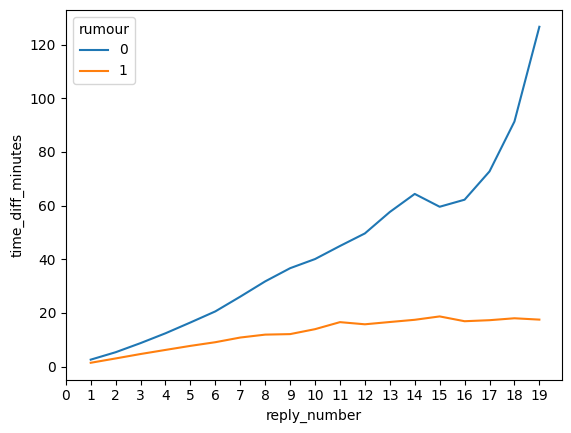

In [13]:
sns.lineplot(data=df_reply_time, x='reply_number', y='time_diff_minutes',hue='rumour')
# Set custom x-axis values
custom_xticks = np.arange(0,20,1) # specify the desired x-axis values
plt.xticks(custom_xticks)
plt.show()

#### Time for first reply x Number of replies

In [14]:
df_first_tm_diff = df.groupby(['id','rumour']).agg(replies=('time_diff','count')\
                      ,first_time_diff=('time_diff','first')).reset_index()\
                  .groupby(['rumour','replies'])['first_time_diff'].median()\
                  .to_frame().reset_index()

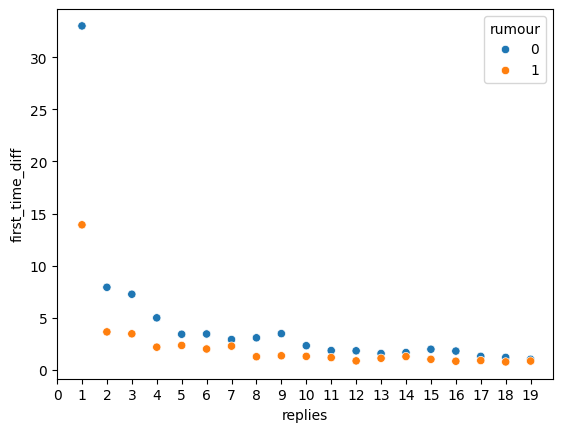

In [15]:
sns.scatterplot(data=df_first_tm_diff, x='replies', y='first_time_diff',hue='rumour')
custom_xticks = np.arange(0,20,1) # specify the desired x-axis values
plt.xticks(custom_xticks)
plt.show()

#### Number of replies x Retweet counts

In [16]:
df_posts = df[['id','text','followers','favorite_count','retweet_count','verified',\
  'rumour','user_id']].drop_duplicates().merge(df.groupby(['id']).agg(replies=(\
  'time_diff','count'),first_time_diff=('time_diff','first')).reset_index(),\
  on="id",how="left")

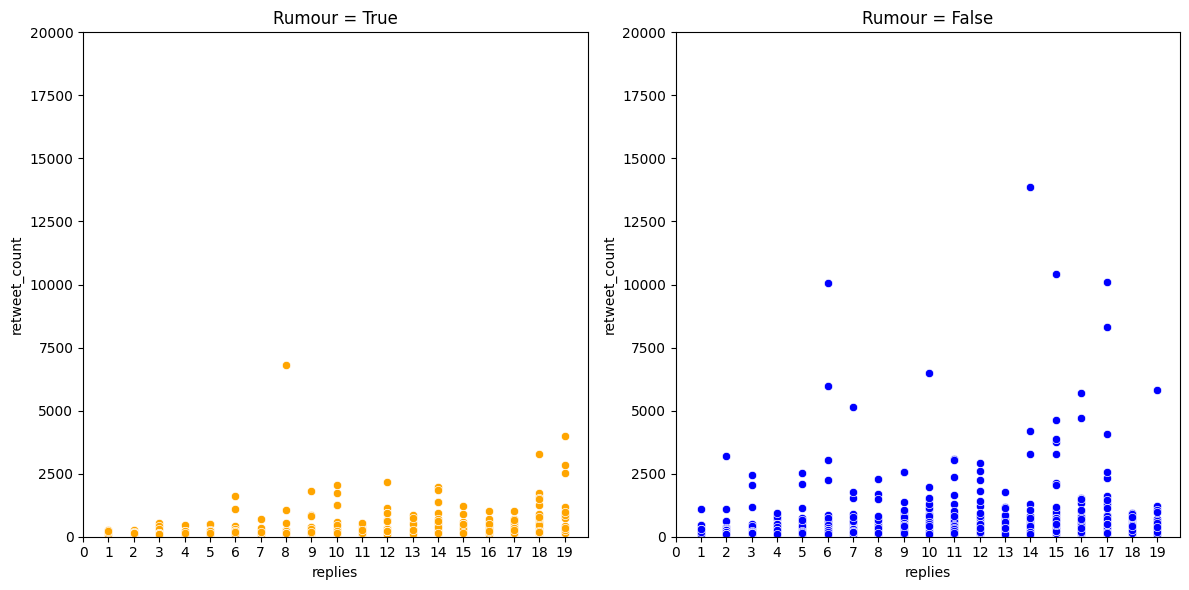

In [17]:
# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Scatter plot for rumour == True
sns.scatterplot(data=df_posts[df_posts['rumour'] == 1], x='replies', y='retweet_count',color='orange', ax=axs[0])
axs[0].set_title('Rumour = True')
#axs[0].set_xlim(0, 5000)
axs[0].set_ylim(0, 20000)
custom_xticks = np.arange(0, 20, 1)
axs[0].set_xticks(custom_xticks)

# Scatter plot for rumour == False
sns.scatterplot(data=df_posts[df_posts['rumour'] == 0], x='replies', y='retweet_count',color='blue', ax=axs[1])
axs[1].set_title('Rumour = False')
#axs[1].set_xlim(0, 5000)
axs[1].set_ylim(0, 20000)
custom_xticks = np.arange(0, 20, 1)
axs[1].set_xticks(custom_xticks)

plt.tight_layout()
plt.show()

#### Favorite counts x Retweet counts

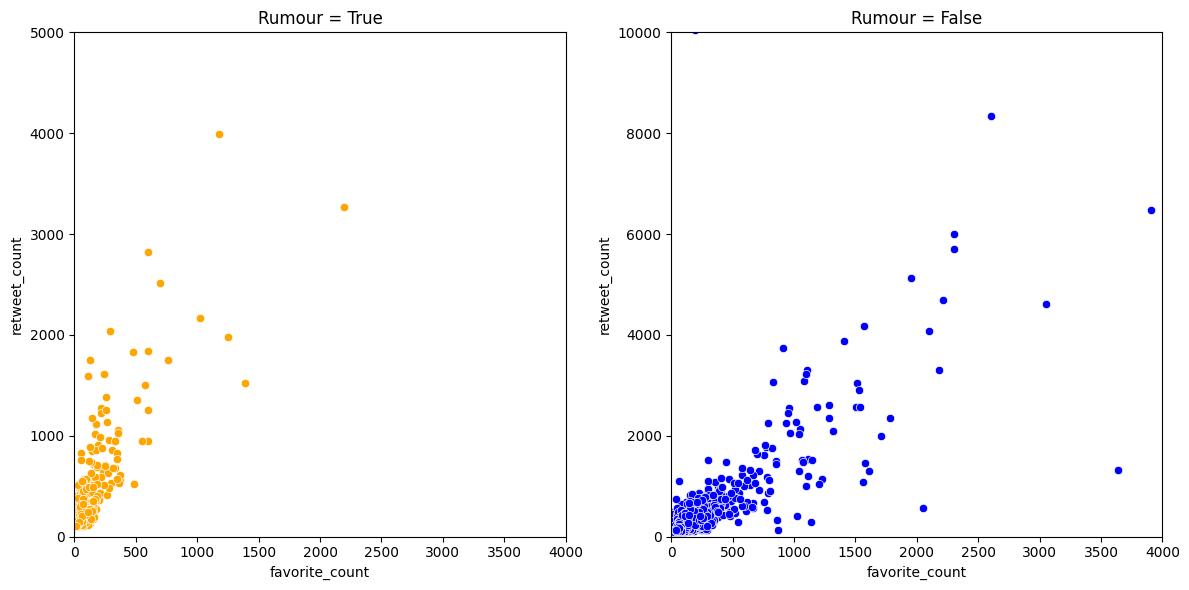

In [18]:
# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Scatter plot for rumour == True
sns.scatterplot(data=df_posts[df_posts['rumour'] == 1], x='favorite_count', y='retweet_count',color='orange', ax=axs[0])
axs[0].set_title('Rumour = True')
axs[0].set_xlim(0, 4000)
axs[0].set_ylim(0, 5000)

# Scatter plot for rumour == False
sns.scatterplot(data=df_posts[df_posts['rumour'] == 0], x='favorite_count', y='retweet_count',color='blue', ax=axs[1])
axs[1].set_title('Rumour = False')
axs[1].set_xlim(0, 4000)
axs[1].set_ylim(0, 10000)


plt.tight_layout()
plt.show()

#### Retweet count x Time for first reply

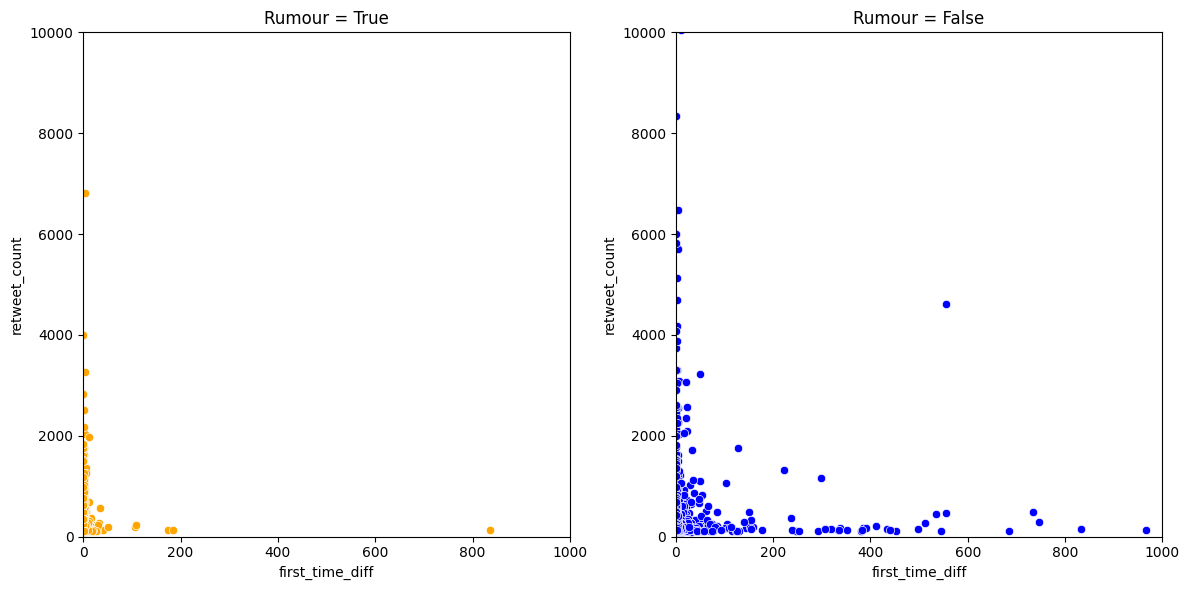

In [19]:
# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Scatter plot for rumour == True
sns.scatterplot(data=df_posts[df_posts['rumour'] == 1], x='first_time_diff', y='retweet_count',color='orange', ax=axs[0])
axs[0].set_title('Rumour = True')
axs[0].set_xlim(0, 1000)
axs[0].set_ylim(0, 10000)

# Scatter plot for rumour == False
sns.scatterplot(data=df_posts[df_posts['rumour'] == 0], x='first_time_diff', y='retweet_count',color='blue', ax=axs[1])
axs[1].set_title('Rumour = False')
axs[1].set_xlim(0, 1000)
axs[1].set_ylim(0, 10000)


plt.tight_layout()
plt.show()

#### Followers vs Retweet counts

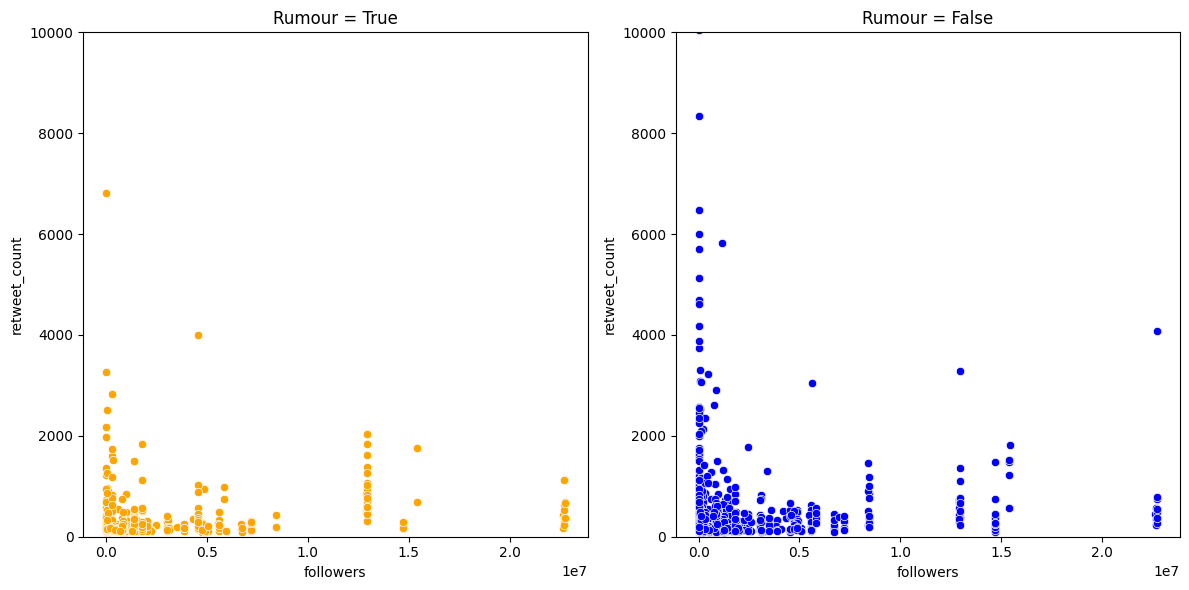

In [20]:
# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Scatter plot for rumour == True
sns.scatterplot(data=df_posts[df_posts['rumour'] == 1], x='followers', y='retweet_count',color='orange', ax=axs[0])
axs[0].set_title('Rumour = True')
#axs[0].set_xlim(0, 1000)
axs[0].set_ylim(0, 10000)

# Scatter plot for rumour == False
sns.scatterplot(data=df_posts[df_posts['rumour'] == 0], x='followers', y='retweet_count',color='blue', ax=axs[1])
axs[1].set_title('Rumour = False')
#axs[1].set_xlim(0, 1000)
axs[1].set_ylim(0, 10000)


plt.tight_layout()
plt.show()

#### Word embeddings

In [21]:
# Download NLTK stopwords
nltk.download('stopwords')

english_stopwords = nltk.corpus.stopwords.words('english')

# function for cleaning data
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt


def clean_text(
    string: str,
    punctuations=r'''!()-[]{};:'"\,<>./?@#$%^&*_~''',
    stop_words=english_stopwords) -> str:
    """
    A method to clean text
    """
    # Cleaning the urls
    string = re.sub(r'https?://\S+|www\.\S+', '', string)

    # Cleaning the html elements
    string = re.sub(r'<.*?>', '', string)

    # Removing the punctuations
    for x in string.lower():
        if x in punctuations:
            string = string.replace(x, "")

    # Converting the text to lower
    string = string.lower()

    # Removing stop words
    string = ' '.join([word for word in string.split() if word not in stop_words])

    # Cleaning the whitespaces
    string = re.sub(r'\s+', ' ', string).strip()

    return string

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
df_posts['clean_text'] = np.vectorize(remove_pattern)(df_posts['text'], "@[\w]*")
df_posts['clean_text'] = df_posts['clean_text'].str.replace("[^a-zA-Z#]", " ").apply(clean_text)

In [23]:
# create the dictionary
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_posts['clean_text'])

In [24]:
print("Longest length is: ",df_posts.clean_text.str.len().max())

Longest length is:  127


In [25]:
def embedding_vocab(filepath, word_index,embedding_dim):
    vocab_size = len(word_index) + 1


    embedding_matrix_vocab = np.zeros((vocab_size,
                                       embedding_dim))

    with open(filepath, encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix_vocab[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix_vocab

In [26]:
#!wget https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
#!unzip -q glove.6B.zip

In [27]:
embedding_dim = 100
embedding_matrix_vocab = embedding_vocab(
    'glove.6B.100d.txt', tokenizer.word_index,
embedding_dim)

In [28]:
tokenizer.word_index['terrorist']

32

In [29]:
embedding_matrix_vocab[32]

array([ 2.61329988e-04,  3.27170014e-01, -5.27490020e-01, -6.99689984e-01,
        5.68310022e-01, -1.64810002e-01, -4.63490009e-01, -1.06669998e+00,
        7.11060017e-02,  1.34609997e+00,  4.05539989e-01,  7.92929977e-02,
        5.70400000e-01,  4.85280007e-01,  1.60490006e-01,  1.35200000e+00,
       -6.25209987e-01, -9.24429968e-02, -9.80400026e-01,  4.38950002e-01,
        1.12310000e-01, -2.42149994e-01,  2.77770013e-01, -7.61640012e-01,
       -9.54079986e-01,  3.74170005e-01,  4.12420005e-01,  9.61040035e-02,
        8.47470015e-02,  2.55450010e-01,  4.38340008e-01, -1.25060007e-01,
       -1.60779998e-01,  1.24240004e-01,  1.52309999e-01, -1.64389998e-01,
       -3.27900015e-02, -4.91930008e-01,  5.06540000e-01,  2.00389996e-01,
       -5.87509990e-01,  2.10769996e-01,  1.22230005e+00,  5.09630024e-01,
        1.11189997e+00, -2.26009995e-01,  9.64810014e-01,  6.00089990e-02,
       -6.84650004e-01, -3.28599989e-01,  2.12280005e-02,  9.96940017e-01,
        5.38230002e-01,  

In [30]:
from sklearn.metrics.pairwise import cosine_similarity

def cosine_similarities(embedding_matrix, word_index, word):
    idx = word_index.get(word)
    if idx is None:
        return None
    vector = embedding_matrix[idx].reshape(1, -1)
    similarities = cosine_similarity(vector, embedding_matrix)
    return similarities[0]

In [31]:
similarities = cosine_similarities(embedding_matrix_vocab, tokenizer.word_index, 'terrorist')
similar_indices = similarities.argsort()[::-1]
for idx in similar_indices[1:6]:  # excluding the word itself
    word = tokenizer.index_word[idx]
    print(word)

terror
terrorists
terrorism
attacks
qaeda


In [32]:
similarities = cosine_similarities(embedding_matrix_vocab, tokenizer.word_index, 'cowards')
similar_indices = similarities.argsort()[::-1]
for idx in similar_indices[1:6]:  # excluding the word itself
    word = tokenizer.index_word[idx]
    print(word)

hypocrites
morons
savages
idiots
cowardly


In [33]:
# Tokenize text
sequences = tokenizer.texts_to_sequences(df_posts['clean_text'])

# Padding sequences if necessary
max_sequence_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

# Function to get embeddings for a sequence
def get_embeddings(sequence, embedding_matrix):
    embeddings = []
    for idx in sequence:
        embeddings.append(embedding_matrix[idx])
    return np.array(embeddings)

# Apply function to get embeddings for each sequence
df_posts['embeddings'] = [get_embeddings(seq, embedding_matrix_vocab) for seq in sequences]

In [34]:
array_avg = []
for i in df_posts.embeddings:
  array_avg.append(np.mean(i,axis=0))
df_posts['embeddings_avg'] = array_avg

In [35]:
idx =1522
vector = df_posts.iloc[idx].embeddings_avg.reshape(1,100)
embedding_matrix = np.vstack(df_posts.embeddings_avg.values)
similarities = cosine_similarity(vector, embedding_matrix)[0]

similar_indices = similarities.argsort()[::-1]
print(df_posts.iloc[idx].text,"\n")
for idx in similar_indices[1:6]:  # excluding the word itself
    tweet = df_posts.iloc[idx].text
    print(tweet)

Details of attacks on Muslim community in France, grenades, &amp; shootings in aftermath of the #CharlieHebdo attack http://t.co/4u5fsWL75w 

Two mosque attacks reported in wake of Charlie Hebdo attack  
http://t.co/mPr3rXnx7i #C4News
French leader: Attack that killed 11 at Paris newspaper an act of terror, other attacks thwarted in recent weeks: http://t.co/9rrqfEaQj5
Revenge attacks on Muslim spaces begin in France after #CharlieHebdo massacre http://t.co/50anhW9BEk http://t.co/uKL5El7V2B
A shocking number of attacks against French Muslims and mosques days after the #CharlieHebdo massacre: http://t.co/0DokPJ98EB
France: Since last night, gunfire and bombings have targeted two mosques, a prayer room, and a Muslim family's car. http://t.co/fXrG6y2uvX


#### Reply embeddings

In [36]:
df['clean_reply_text'] = np.vectorize(remove_pattern)(df['reply_text'], "@[\w]*")
df['clean_reply_text'] = df['clean_reply_text'].str.replace("[^a-zA-Z#]", " ").apply(clean_text)

In [37]:
# create the dictionary
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['clean_reply_text'])

In [38]:
embedding_dim = 100
embedding_matrix_vocab = embedding_vocab(
    'glove.6B.100d.txt', tokenizer.word_index,
embedding_dim)

In [39]:
# Tokenize text
sequences = tokenizer.texts_to_sequences(df['clean_reply_text'])

# Padding sequences if necessary
max_sequence_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

# Apply function to get embeddings for each sequence
df['reply_embeddings'] = [get_embeddings(seq, embedding_matrix_vocab) for seq in sequences]

In [40]:
array_avg = []
for i in df.reply_embeddings:
  array_avg.append(np.mean(i,axis=0))
df['reply_embeddings_avg'] = array_avg

/home/codespace/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/codespace/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [41]:

df['reply_embeddings_avg'] = df['reply_embeddings_avg'].apply(lambda x: x if isinstance(x, np.ndarray) else np.zeros(100))